In [1]:
#!pip install gensim --upgrade
#!pip install keras --upgrade
#!pip install pandas --upgrade

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ac36345\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)
# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

Dataset details
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
ids: The id of the tweet ( 2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)

In [9]:
#dataset_filename = os.listdir("C:\\Users\\ac36345\\Desktop\\Nlp Data\\Twitter")[0]
df = pd.read_csv("C:\\Users\\ac36345\\Desktop\\Nlp Data\\Twitter\\training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [10]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [11]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [13]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 1.48 s


In [14]:
df.head(2)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


Text(0.5, 1.0, 'Dataset labels distribuition')

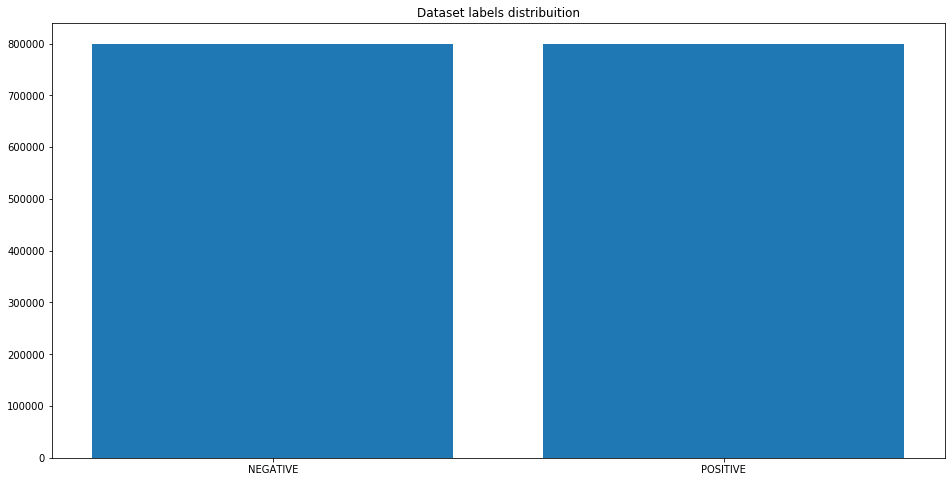

In [15]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [16]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [17]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [18]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 51s


In [19]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [20]:
df_train.text

1374558    ya quot like palm pre touchstone charger ready...
1389115            felt earthquake afternoon seems epicenter
1137831                            ruffles shirts like likey
790714     pretty bad night crappy morning fml buttface d...
1117911                                      yeah clear view
                                 ...                        
259178                  song middle change want born arghhhh
1414414                                            good luck
131932                                  rather average 32370
671155     pickin misstinayao waitin sadittysash 2 hurry ...
121958          home studying maths wooot im going fail shit
Name: text, Length: 1280000, dtype: object

In [25]:
#%%time
documents = [_text.split() for _text in df_train.text] 
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)

2020-01-24 08:56:48,654 : INFO : collecting all words and their counts
2020-01-24 08:56:48,654 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-24 08:56:48,690 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-01-24 08:56:48,715 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-01-24 08:56:48,760 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-01-24 08:56:48,800 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-01-24 08:56:48,840 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-01-24 08:56:48,872 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-01-24 08:56:48,924 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-01-24 08:56:48,975 : INFO : PROGRESS: at s

2020-01-24 08:56:51,482 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-01-24 08:56:51,508 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-01-24 08:56:51,535 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-01-24 08:56:51,577 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-01-24 08:56:51,622 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-01-24 08:56:51,691 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-01-24 08:56:51,742 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-01-24 08:56:51,793 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-01-24 08:56:51,872 : INFO : PROGRESS: at sentence #800000, processed 577088

In [26]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [27]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-01-24 08:57:22,784 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-01-24 08:57:23,812 : INFO : EPOCH 1 - PROGRESS: at 5.54% examples, 451077 words/s, in_qsize 14, out_qsize 1
2020-01-24 08:57:24,814 : INFO : EPOCH 1 - PROGRESS: at 12.06% examples, 492677 words/s, in_qsize 15, out_qsize 0
2020-01-24 08:57:25,830 : INFO : EPOCH 1 - PROGRESS: at 18.65% examples, 507029 words/s, in_qsize 16, out_qsize 0
2020-01-24 08:57:26,835 : INFO : EPOCH 1 - PROGRESS: at 25.59% examples, 522207 words/s, in_qsize 14, out_qsize 1
2020-01-24 08:57:27,868 : INFO : EPOCH 1 - PROGRESS: at 32.41% examples, 526803 words/s, in_qsize 15, out_qsize 0
2020-01-24 08:57:28,899 : INFO : EPOCH 1 - PROGRESS: at 38.14% examples, 515232 words/s, in_qsize 16, out_qsize 1
2020-01-24 08:57:29,923 : INFO : EPOCH 1 - PROGRESS: at 44.29% examples, 512589 words/s, in_qsize 16, out_qsize 0
2020-01-24 08:57:30,932 : INFO : EPOCH 1 - PROGRESS: 

2020-01-24 08:58:13,330 : INFO : EPOCH 4 - PROGRESS: at 26.99% examples, 545267 words/s, in_qsize 16, out_qsize 0
2020-01-24 08:58:14,356 : INFO : EPOCH 4 - PROGRESS: at 33.38% examples, 538666 words/s, in_qsize 14, out_qsize 1
2020-01-24 08:58:15,365 : INFO : EPOCH 4 - PROGRESS: at 39.86% examples, 537229 words/s, in_qsize 15, out_qsize 0
2020-01-24 08:58:16,384 : INFO : EPOCH 4 - PROGRESS: at 46.78% examples, 540376 words/s, in_qsize 14, out_qsize 1
2020-01-24 08:58:17,479 : INFO : EPOCH 4 - PROGRESS: at 53.38% examples, 534585 words/s, in_qsize 16, out_qsize 1
2020-01-24 08:58:18,529 : INFO : EPOCH 4 - PROGRESS: at 59.98% examples, 532643 words/s, in_qsize 13, out_qsize 2
2020-01-24 08:58:19,561 : INFO : EPOCH 4 - PROGRESS: at 67.02% examples, 535508 words/s, in_qsize 13, out_qsize 2
2020-01-24 08:58:20,595 : INFO : EPOCH 4 - PROGRESS: at 74.70% examples, 542418 words/s, in_qsize 14, out_qsize 1
2020-01-24 08:58:21,612 : INFO : EPOCH 4 - PROGRESS: at 81.23% examples, 540961 words/s,

2020-01-24 08:59:06,451 : INFO : EPOCH 7 - PROGRESS: at 82.21% examples, 554258 words/s, in_qsize 15, out_qsize 0
2020-01-24 08:59:07,476 : INFO : EPOCH 7 - PROGRESS: at 88.91% examples, 553174 words/s, in_qsize 16, out_qsize 2
2020-01-24 08:59:08,482 : INFO : EPOCH 7 - PROGRESS: at 96.21% examples, 555942 words/s, in_qsize 15, out_qsize 0
2020-01-24 08:59:08,899 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-24 08:59:08,902 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-24 08:59:08,904 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-24 08:59:08,907 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-24 08:59:08,911 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-24 08:59:08,931 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-24 08:59:08,934 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-24 08:59:08,9

2020-01-24 08:59:52,939 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-24 08:59:52,949 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-24 08:59:52,959 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-24 08:59:52,961 : INFO : EPOCH - 10 : training on 9227204 raw words (8223978 effective words) took 14.4s, 569411 effective words/s
2020-01-24 08:59:54,015 : INFO : EPOCH 11 - PROGRESS: at 6.19% examples, 496594 words/s, in_qsize 16, out_qsize 0
2020-01-24 08:59:55,031 : INFO : EPOCH 11 - PROGRESS: at 13.14% examples, 528860 words/s, in_qsize 15, out_qsize 0
2020-01-24 08:59:56,088 : INFO : EPOCH 11 - PROGRESS: at 20.27% examples, 538043 words/s, in_qsize 15, out_qsize 0
2020-01-24 08:59:57,118 : INFO : EPOCH 11 - PROGRESS: at 27.10% examples, 539733 words/s, in_qsize 14, out_qsize 1
2020-01-24 08:59:58,157 : INFO : EPOCH 11 - PROGRESS: at 33.81% examples, 538161 words/s, in_qsize 15, out_qsize 0
2020-01-24 08:

2020-01-24 09:00:42,612 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-24 09:00:42,614 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-24 09:00:42,615 : INFO : EPOCH - 13 : training on 9227204 raw words (8221465 effective words) took 16.8s, 490629 effective words/s
2020-01-24 09:00:43,639 : INFO : EPOCH 14 - PROGRESS: at 5.75% examples, 468980 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:00:44,646 : INFO : EPOCH 14 - PROGRESS: at 11.95% examples, 486688 words/s, in_qsize 14, out_qsize 1
2020-01-24 09:00:45,694 : INFO : EPOCH 14 - PROGRESS: at 18.32% examples, 491658 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:00:46,693 : INFO : EPOCH 14 - PROGRESS: at 24.39% examples, 493485 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:00:47,696 : INFO : EPOCH 14 - PROGRESS: at 30.35% examples, 492546 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:00:48,757 : INFO : EPOCH 14 - PROGRESS: at 35.64% examples, 478568 words/s, in_qsize 15, ou

2020-01-24 09:01:31,894 : INFO : EPOCH 17 - PROGRESS: at 6.51% examples, 533819 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:01:32,905 : INFO : EPOCH 17 - PROGRESS: at 12.93% examples, 526720 words/s, in_qsize 14, out_qsize 1
2020-01-24 09:01:33,926 : INFO : EPOCH 17 - PROGRESS: at 19.84% examples, 537529 words/s, in_qsize 14, out_qsize 1
2020-01-24 09:01:34,930 : INFO : EPOCH 17 - PROGRESS: at 26.45% examples, 538597 words/s, in_qsize 16, out_qsize 0
2020-01-24 09:01:35,932 : INFO : EPOCH 17 - PROGRESS: at 33.48% examples, 546301 words/s, in_qsize 14, out_qsize 1
2020-01-24 09:01:36,974 : INFO : EPOCH 17 - PROGRESS: at 40.40% examples, 546382 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:01:37,985 : INFO : EPOCH 17 - PROGRESS: at 46.89% examples, 543737 words/s, in_qsize 16, out_qsize 0
2020-01-24 09:01:38,986 : INFO : EPOCH 17 - PROGRESS: at 53.70% examples, 545795 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:01:39,998 : INFO : EPOCH 17 - PROGRESS: at 60.09% examples, 543064 

2020-01-24 09:02:22,866 : INFO : EPOCH 20 - PROGRESS: at 54.13% examples, 542379 words/s, in_qsize 16, out_qsize 0
2020-01-24 09:02:23,889 : INFO : EPOCH 20 - PROGRESS: at 61.50% examples, 547972 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:02:24,891 : INFO : EPOCH 20 - PROGRESS: at 68.10% examples, 547240 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:02:25,896 : INFO : EPOCH 20 - PROGRESS: at 74.48% examples, 545157 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:02:26,910 : INFO : EPOCH 20 - PROGRESS: at 81.12% examples, 544427 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:02:27,946 : INFO : EPOCH 20 - PROGRESS: at 88.48% examples, 547510 words/s, in_qsize 14, out_qsize 1
2020-01-24 09:02:28,955 : INFO : EPOCH 20 - PROGRESS: at 95.55% examples, 549300 words/s, in_qsize 16, out_qsize 0
2020-01-24 09:02:29,429 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-24 09:02:29,446 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-24 09

2020-01-24 09:03:13,255 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-24 09:03:13,280 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-24 09:03:13,285 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-24 09:03:13,292 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-24 09:03:13,295 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-24 09:03:13,312 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-24 09:03:13,315 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-24 09:03:13,324 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-24 09:03:13,327 : INFO : EPOCH - 23 : training on 9227204 raw words (8222534 effective words) took 14.6s, 565080 effective words/s
2020-01-24 09:03:14,362 : INFO : EPOCH 24 - PROGRESS: at 5.97% examples, 486709 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:03:15

2020-01-24 09:03:58,746 : INFO : EPOCH 27 - PROGRESS: at 5.97% examples, 478887 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:03:59,756 : INFO : EPOCH 27 - PROGRESS: at 12.28% examples, 495502 words/s, in_qsize 14, out_qsize 1
2020-01-24 09:04:00,758 : INFO : EPOCH 27 - PROGRESS: at 18.54% examples, 502103 words/s, in_qsize 14, out_qsize 1
2020-01-24 09:04:01,773 : INFO : EPOCH 27 - PROGRESS: at 24.83% examples, 503980 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:04:02,782 : INFO : EPOCH 27 - PROGRESS: at 31.10% examples, 505509 words/s, in_qsize 14, out_qsize 1
2020-01-24 09:04:03,785 : INFO : EPOCH 27 - PROGRESS: at 38.35% examples, 520233 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:04:04,800 : INFO : EPOCH 27 - PROGRESS: at 44.83% examples, 521161 words/s, in_qsize 16, out_qsize 0
2020-01-24 09:04:05,804 : INFO : EPOCH 27 - PROGRESS: at 51.53% examples, 524893 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:04:06,805 : INFO : EPOCH 27 - PROGRESS: at 58.14% examples, 526757 

2020-01-24 09:04:50,484 : INFO : EPOCH 30 - PROGRESS: at 47.65% examples, 549565 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:04:51,489 : INFO : EPOCH 30 - PROGRESS: at 54.56% examples, 551839 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:04:52,501 : INFO : EPOCH 30 - PROGRESS: at 61.50% examples, 553114 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:04:53,503 : INFO : EPOCH 30 - PROGRESS: at 68.21% examples, 552954 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:04:54,512 : INFO : EPOCH 30 - PROGRESS: at 74.92% examples, 552406 words/s, in_qsize 14, out_qsize 1
2020-01-24 09:04:55,508 : INFO : EPOCH 30 - PROGRESS: at 81.77% examples, 553009 words/s, in_qsize 15, out_qsize 0
2020-01-24 09:04:56,541 : INFO : EPOCH 30 - PROGRESS: at 88.70% examples, 553192 words/s, in_qsize 16, out_qsize 0
2020-01-24 09:04:57,557 : INFO : EPOCH 30 - PROGRESS: at 95.55% examples, 553044 words/s, in_qsize 16, out_qsize 0
2020-01-24 09:04:58,048 : INFO : worker thread finished; awaiting finish of 7 mo

Wall time: 8min 5s


(263125295, 295270528)

In [30]:
#%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419


In [ ]:
w2v_model.most_similar("love")

In [31]:
#%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [32]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [33]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [34]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [35]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [36]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [37]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [38]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2020-01-24 09:20:08,234 : WARNING : From C:\Users\ac36345\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [39]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [40]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
#%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


2020-01-24 09:20:51,279 : WARNING : From C:\Users\ac36345\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 7620s 7ms/step - loss: 0.5052 - accuracy: 0.7496 - val_loss: 0.4624 - val_accuracy: 0.7798


C:\Users\ac36345\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/8
1152000/1152000 [==============================] - 7164s 6ms/step - loss: 0.4820 - accuracy: 0.7650 - val_loss: 0.4562 - val_accuracy: 0.7837
Epoch 3/8
 790528/1152000 [===================>..........] - ETA: 1:08:41 - loss: 0.4750 - accuracy: 0.7697

In [ ]:
#evaluate
#%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
#Predict
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

In [ ]:
#%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
#%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
#clasification report
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
#accuracy score
accuracy_score(y_test_1d, y_pred_1d)

In [ ]:
#save model
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)